In [43]:
!pip install sklearn

You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
#from sklearn.cross_validation import train_test_split
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import StandardScalerModel
%matplotlib inline

# Loading and Cleansing Data

In [45]:
# read data into pandas dataframe from csv
df = pd.read_csv('cars.csv')

In [46]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


### Checking for Null Values

This particular data file annotates missing values with a question mark.  We will need to clean this dataset accordingly.

In [48]:
! cat cars.csv | grep ?

25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


The Pandas DataFrame API is robust enough to load these values, but we will need to remove them manually.  The Null values shown below will be removed from the dataset.

In [49]:
df[df.horsepower=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [50]:
# remove missing values and convert to float
df = df[df.horsepower != '?']
df['horsepower'] = df.horsepower.map(lambda x: float(x))

# Solving a simple linear regression


## Numpy Analytical Solution

## A column of ones must be added so that $w_0$ corresponds to the intercept.

In [51]:
# use only the horsepower and weight columns as features
def add_const(X):
    return np.concatenate((np.ones(shape=(X.shape[0],1)),X),axis=1)
X = df[['horsepower', 'weight']]
# add a column of ones so that there can be an intercept term
X = add_const(X)
y = df.mpg.values
print(X)

[[1.000e+00 1.300e+02 3.504e+03]
 [1.000e+00 1.650e+02 3.693e+03]
 [1.000e+00 1.500e+02 3.436e+03]
 ...
 [1.000e+00 8.400e+01 2.295e+03]
 [1.000e+00 7.900e+01 2.625e+03]
 [1.000e+00 8.200e+01 2.720e+03]]


Here we will be looking at Two Features:  Horsepower and Weight 

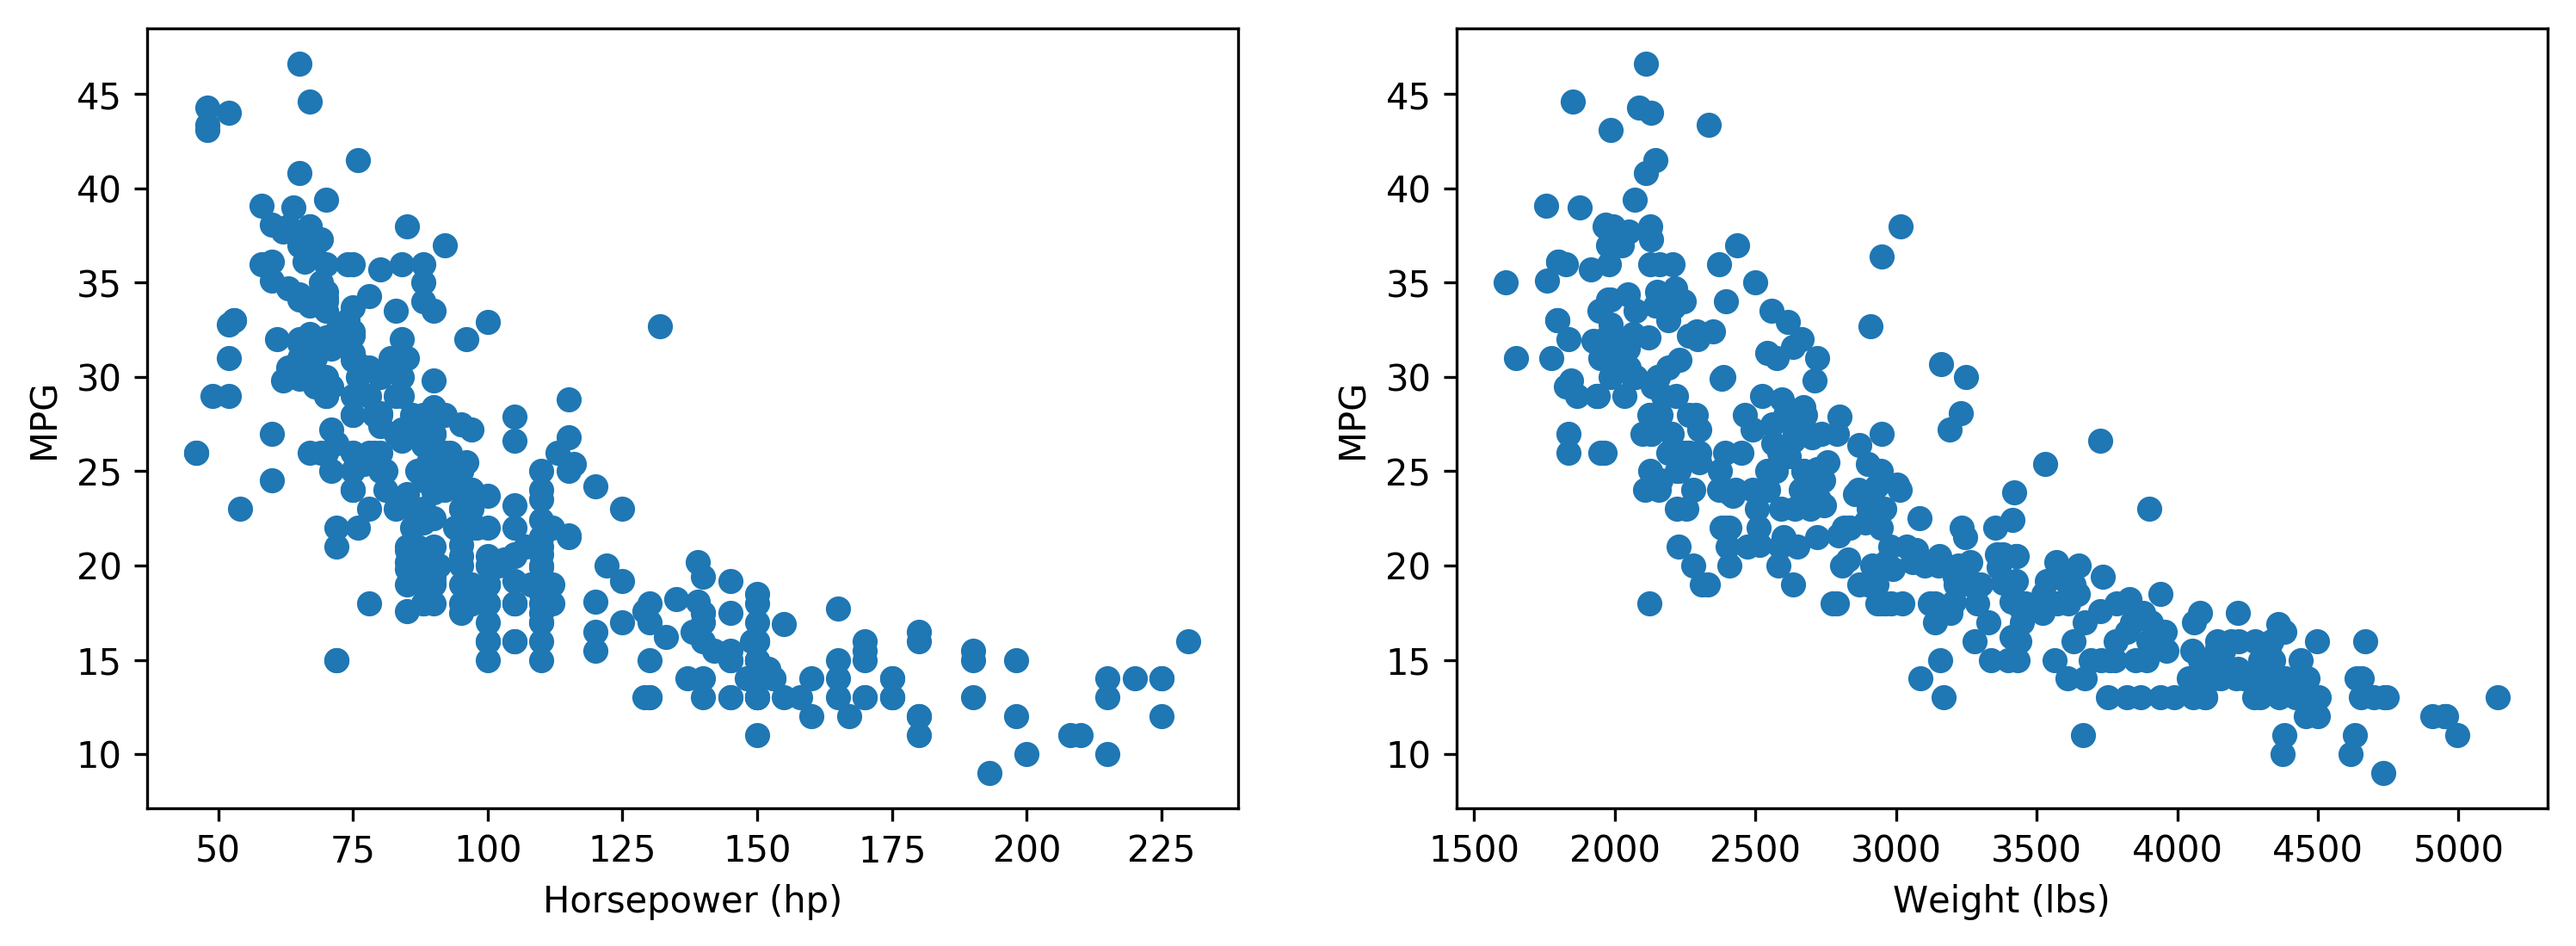

In [52]:
dpi = 300 #dots per square inch when plotting...higher resolution for publications.
plt.rcParams['figure.dpi']= dpi
# TODO:  Fix x axis for HP!

#visualize the data
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(df.horsepower, df.mpg)
axs[0].set_xlabel('Horsepower (hp)')
axs[0].set_ylabel('MPG')
axs[1].scatter(df.weight, df.mpg)
axs[1].set_xlabel('Weight (lbs)')
axs[1].set_ylabel('MPG')

## Numpy Analytical Solution:  The Normal Equation

Find the linear least squares solution to the problem:

$$y=\mathbf{X}\mathbf{w}$$

Where $X$ is a matrix of features, with each column corresponding to a certain feature (like horsepower)

The least squares solution is:

$$\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}\\
\mathbf{\hat{y}}=\mathbf{X}\mathbf{\hat{w}}$$

For this notebook, we will only solve the Normal Equation.  In this notebook, we will also present a gradient descent algorithm.

In [53]:
# using numpy matrix objects #see TODO: add link for alternative syntaxes

X_mat = np.mat(X)
y_mat = np.mat(y).T
w_Hat = (X_mat.T*X_mat).I*X_mat.T*y_mat # much more concise
print (np.array(w_Hat).ravel())

[ 4.56402108e+01 -4.73028631e-02 -5.79415736e-03]


In [54]:
# compute the best fit line and find r-squared
y_Hat_NE = np.dot(X, w_Hat)
print( "R-squared (Normal Eqn) = %1.5f" % r2_score(y, y_Hat_NE))

R-squared (Normal Eqn) = 0.70638


# Gradient Descent

The simplest numerical algorithm for solving for parameters numerically is the gradient descent algorithm.  It works for both linear and nonlinear systems.  Since we are able to solve our linear system with the normal equation, we have an excellent opportunity to compare our gradient descent solution to a known solution.  
As the systems become more complex, additional variations to the gradient descent idea are needed to improve performance.  
The parameters are initialized to some guess value, and the gradient is evaluated.  From there, it simply follows the gradient at each step to lower the value of the objective function $S$. 

$$\mathbf{w}_{k+1} =\mathbf{w}_{k} - \nabla_{\mathbf{w}_k} S \cdot \epsilon,$$

where $\epsilon$ is a tunable parameter that allows for the user to specify an optimal step size.  This is often scaled by the number of samples $M$ so that the optimal stepsize is unchanged with respect to the number of samples.  $S$ is defined here as the least squares sum, or residual squared.

$$S = (\mathbf{y}-\mathbf{X}\mathbf{w})^T(\mathbf{y}-\mathbf{X}\mathbf{w})$$

The gradient of this-k objective function is given (without derivation) as
$$\nabla_{\mathbf{w}} S = -2\mathbf{X}^T(\mathbf{y}-\mathbf{X}\mathbf{w}_k)$$

The function is given here.

In [55]:
def gradient_descent_step(w, alpha):
    # Xscaled is global 
    M = Xscaled.shape[0]
    r = y_mat - Xscaled * w
    g = - 2 * Xscaled.T * r
    w = w - 1/M * g * alpha
    rNew = y_mat - Xscaled*w
    S = rNew.T * rNew
    return (w, S[0,0])

# Feature Engineering

The normal equation method does not require any sort of feature scaling.  For Gradient Descent and other related algorithms, however, feature scaling is essential for good performance.  The idea behind feature scaling is to have the range of values in each feature example be similar, so that the optimizer can take gradient steps of similar size in any direction.

## Standardization Scaling of Features

One work around is to scale the input data before the optimization is performed. In this case, scaling the input data means subtracting the mean of each column from the values in that column, and then dividing each value by the standard deviation of the column. In mathematical form:

$$x'_{j,i}=\frac{x_{j,i}-\mu_i}{\sigma_i},$$

where $x_{j,i}$ is the $j$th example of $i$th feature.  There are $N$ features and $M$ examples, and the primed notation $x'_{j,i}$ indicates the scaled feature.  The summary variebles $\mu_i$ and $\sigma$ are the mean and standard deviation of the $ith$ feature, across the $M$ examples respectively.

The bias term $\mathbf{x_0}$ does not need to be rescaled.

The function for scaling the features is presented here.

In [56]:
def standardizationScaler(Xin):
    M, N = Xin.shape
    Xnew=np.matrix(np.copy(Xin))
    mu = np.mean(Xin,axis=0)
    sigma = np.std(Xin,axis=0)
    for i in range(1,N):
            for j in range(M):
                Xnew[j, i] = (Xin[j,i]-mu[0,i])/sigma[0,i]
    print(mu)            
    return (mu, sigma, Xnew)

..and here is what the data looks like after the scaling...

In [57]:
mu, sigma, Xscaled = standardizationScaler(X_mat)
print("original features")
print(X_mat)
print("scaled features")
print(Xscaled)
print ("averages")
print(mu)
print("standard deviations")
print(sigma)

[[1.00000000e+00 1.04469388e+02 2.97758418e+03]]
original features
[[1.000e+00 1.300e+02 3.504e+03]
 [1.000e+00 1.650e+02 3.693e+03]
 [1.000e+00 1.500e+02 3.436e+03]
 ...
 [1.000e+00 8.400e+01 2.295e+03]
 [1.000e+00 7.900e+01 2.625e+03]
 [1.000e+00 8.200e+01 2.720e+03]]
scaled features
[[ 1.          0.66413273  0.62054034]
 [ 1.          1.57459447  0.84333403]
 [ 1.          1.18439658  0.54038176]
 ...
 [ 1.         -0.53247413 -0.80463202]
 [ 1.         -0.66254009 -0.41562716]
 [ 1.         -0.58450051 -0.30364091]]
averages
[[1.00000000e+00 1.04469388e+02 2.97758418e+03]]
standard deviations
[[  0.          38.44203271 848.31844657]]


For reference, we will compute the solution using the normal equation on the scaled features.  We will use this solution as a "ground truth" for comparison.

In [58]:
wNormalEqs = (Xscaled.T*Xscaled).I*Xscaled.T*y_mat # much more concise
print(wNormalEqs.T)

[[23.44591837 -1.81841821 -4.91529057]]


The gradient descent algorithm is carried out here.  We are storing $S$, and $\mathbf{w}$ at each iteration for the purpose of plotting.  These diagnostics introduce inefficiencies, however, and would need to be removed for higher performance approaches.

In [59]:
wP = w_Hat * 0 # setting all betas to zeros using w_Hat for correct size/type
nstepsMax = 100
rFromFit = y_mat - Xscaled*w_Hat
sFromFit = rFromFit.T*rFromFit
sMin = sFromFit*0.99
sIterations=[]
wP, S = gradient_descent_step(wP,0.0) #wP indicates w Prime, which is the scaled parameter
sIterations.append(S)
wIterations = wP

i = 0
alpha = 1e-1  
#f or the adventurous...try alpha = 1e-2, 1, and 5.4e-1 and see what the plots look like!

while i < nstepsMax: #and S > sMin:
    i += 1
    (wP, S) = gradient_descent_step(wP, alpha)
    sIterations.append(S)
    wIterations = np.append(wIterations, wP, axis=1)

Let's plot the evolution of the objective function here

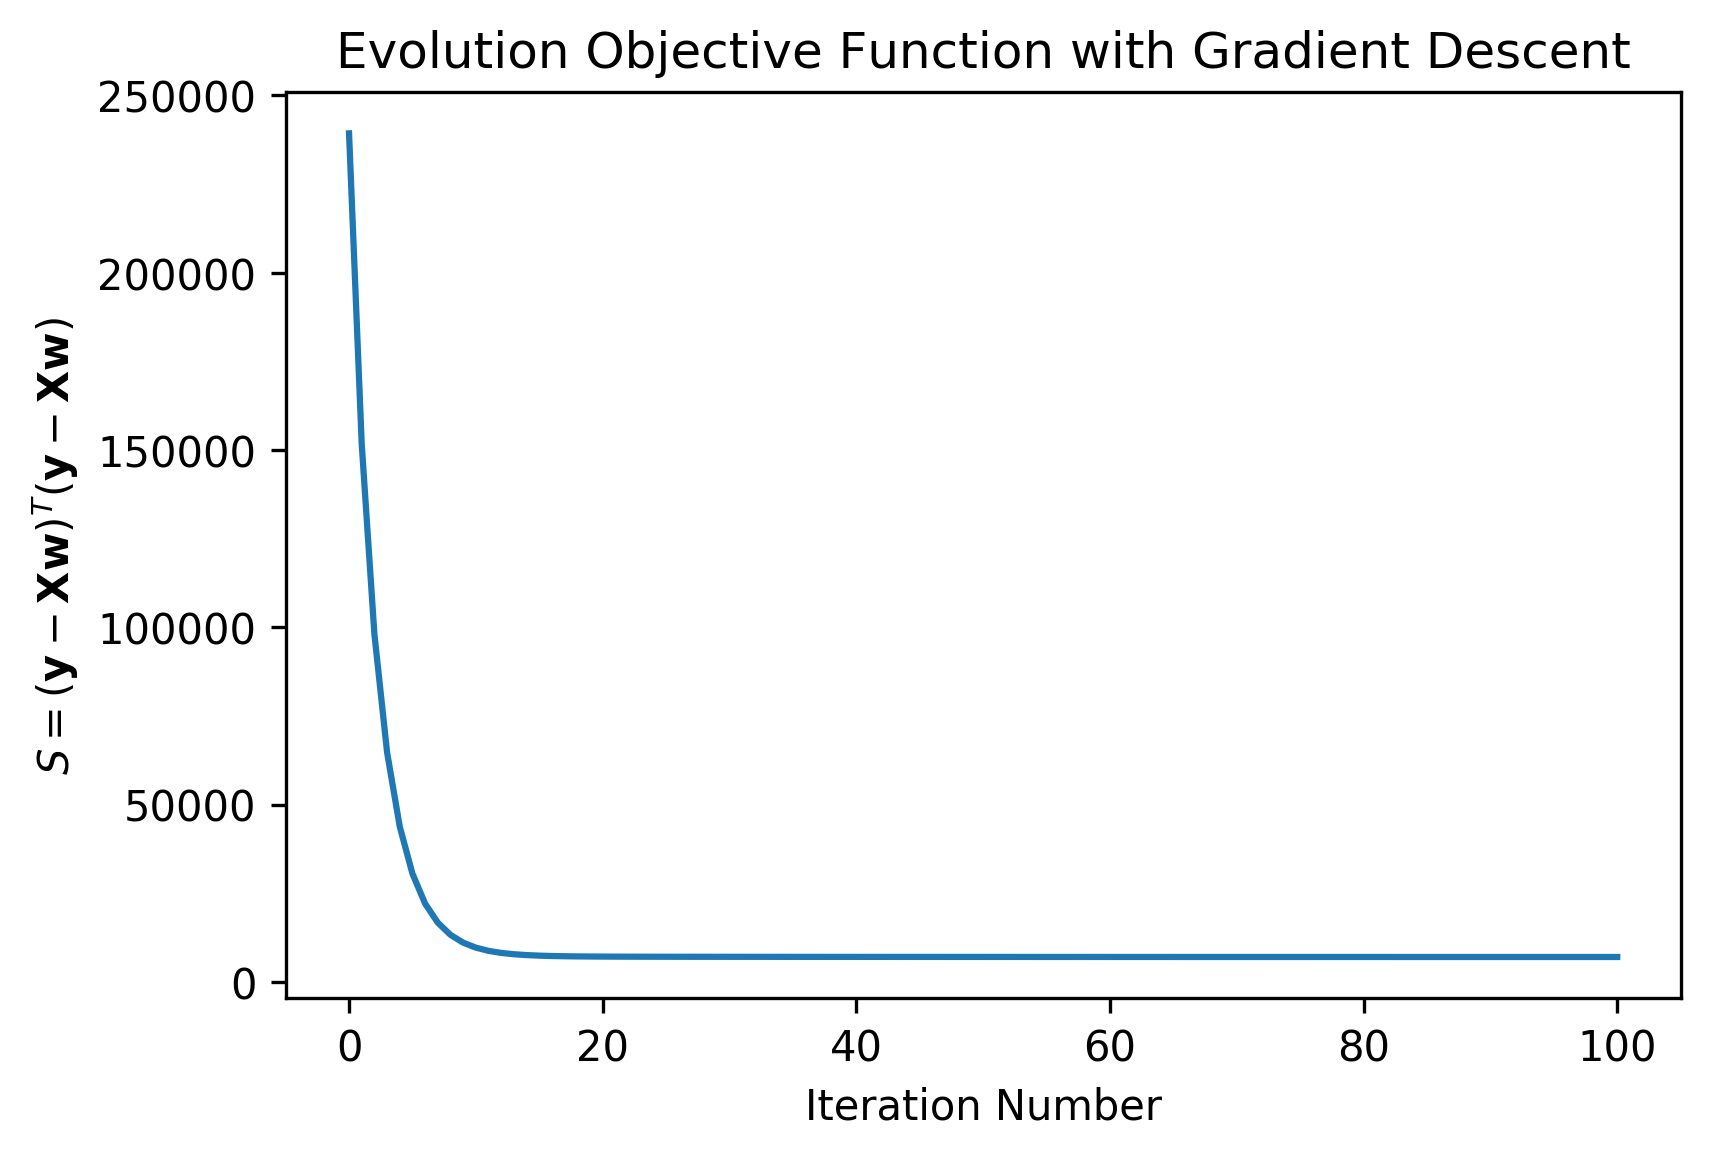

In [60]:
dpi = 300; #dots per square inch when plotting...higher resolution for publications.
plt.rcParams['figure.dpi']= dpi;


plt.plot(sIterations)
plt.xlabel("Iteration Number")
plt.ylabel("$S = (\mathbf{y}-\mathbf{Xw})^T(\mathbf{y}-\mathbf{Xw}) $")
plt.title("Evolution Objective Function with Gradient Descent")
plt.show()


This model generalizes to an arbitrary number of parameters, and large models can have thousands or more parameters.  Thankfully, we only have 3 here, and we can plot their evolution to the "ground truth" solution.

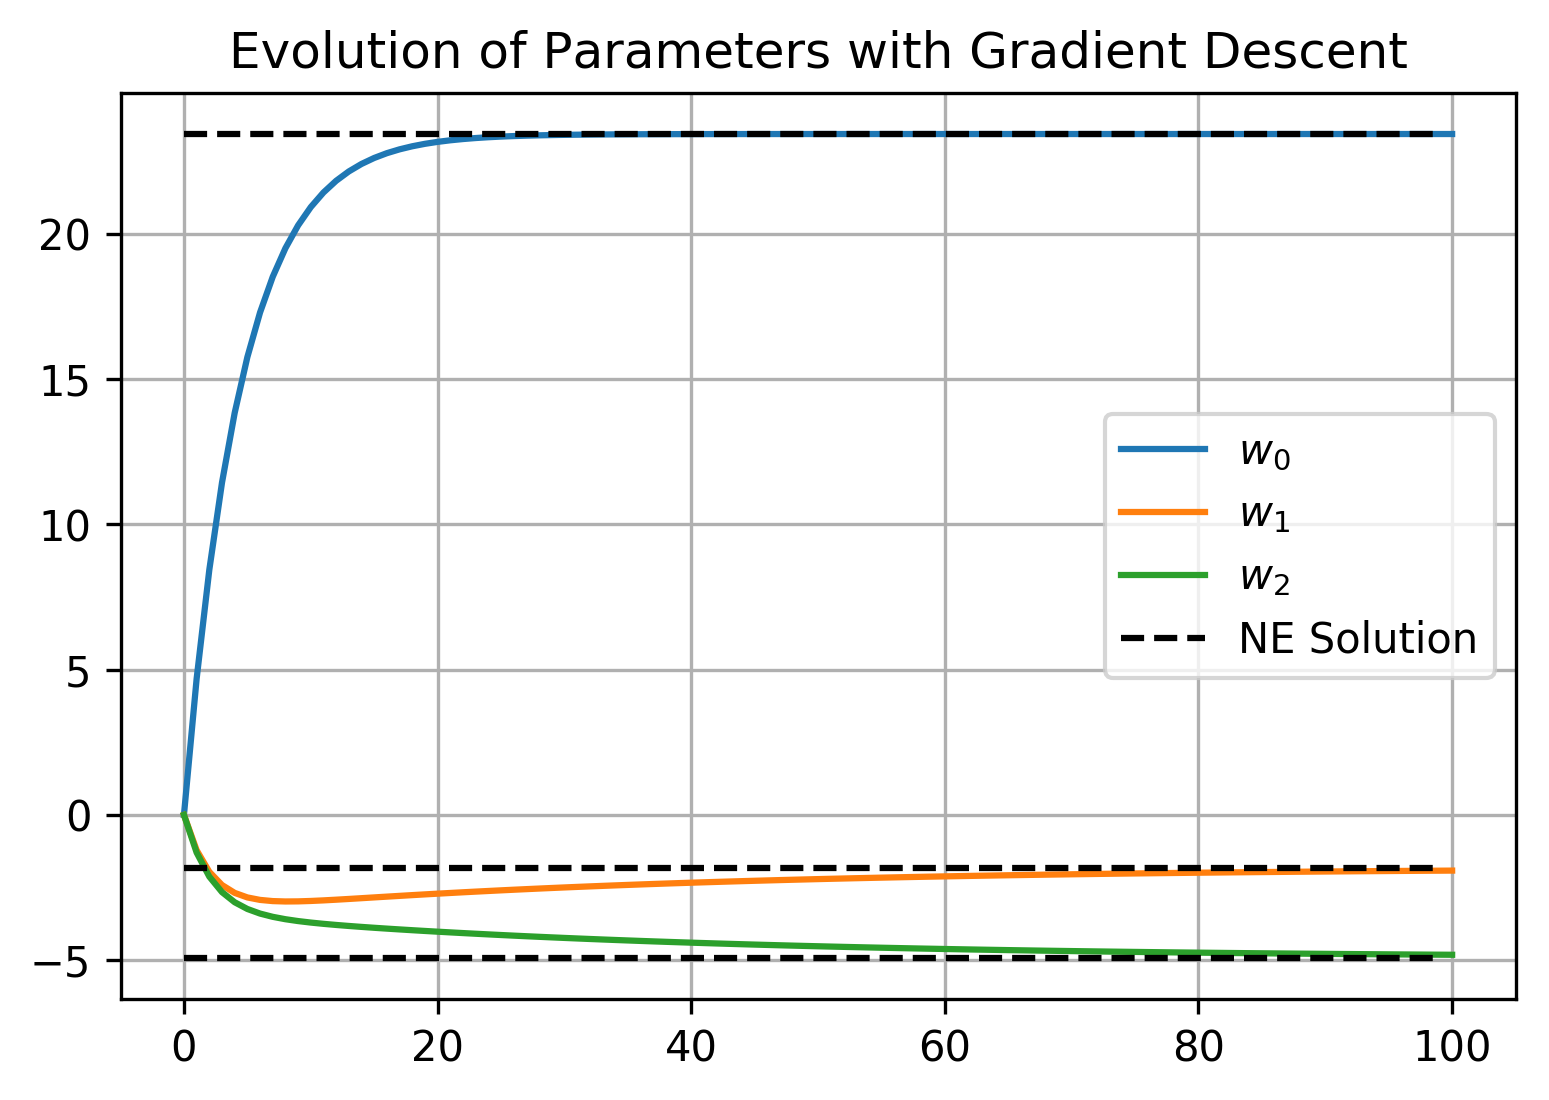

In [61]:
plt.plot( wIterations.T)
#plt.plot(np.arange(0,nstepsMax), np.)
plt.plot(np.ones_like(np.arange(0,nstepsMax))*wNormalEqs[0,0], '--k')
plt.plot(np.ones_like(np.arange(0,nstepsMax))*wNormalEqs[1,0], '--k')
plt.plot(np.ones_like(np.arange(0,nstepsMax))*wNormalEqs[2,0], '--k')
plt.legend(["$w_0$", "$w_1$", "$w_2$", "NE Solution"])
plt.grid("on")
plt.title("Evolution of Parameters with Gradient Descent")

#wIterations

# Rescaling the Parameters for Incoming (Unscaled) Features 

In order to make a prediction with this model, we need to recall that we have solved for parameters using a set of scaled features.  For a new prediction, the features arrive unscaled, and we will need to either
Wmake use the model parameters we have obtained on a new set of features.  We will either need to rescale the features or rescale the parameters.  

Since rescaling the parameters is a one time computation cost, we will do that.  The equations for rescaling the scaled feature parameters $\mathbf{\hat{w}}'$ to the unscaled parameters $\mathbf{\hat{w}}$.


The $j$th prediction $\hat{y}_j$ on the $jth$ scaled feature $\mathbf{x}'_j$ can be written as
$$\hat{y}_j =  \hat{w}'_0 + \sum_{i=1}^{N}\hat{w}'_i x'_{j,i},$$

which can be expressed in terms of the unscaled feature $\mathbf{x}_j'$ as
$$\hat{y}_j =  \hat{w}'_0 + \sum_{i=1}^{N}\hat{w}'_i \frac{x_{j,i}-\mu_i}{\sigma_i}.$$

Expanding the second term out and collecting terms that do not vary with a feature gives
$$\hat{y}_j =  \hat{w}'_0 - \sum_{i=1}^{N}\hat{w}'_i \frac{\mu_i}{\sigma_i} + \sum_{i=1}^{N}w'_i \frac{x_{j,i}}{\sigma_i}$$

Upon inspection, the first two terms are the bias term for the unscaled parameter
$$\hat{w}_0 =   w'_0 - \sum_{i=1}^{N}\hat{w}'_i \frac{\mu_i}{\sigma_i}, $$

and the remaining unscaled parameter terms are given as
$$\hat{w}_i = \frac{\hat{w}'_i}{\sigma_i}.$$

In [62]:
def rescaleWeight(w, mu, sigma):
    N = mu.shape[1]
    wN = wP*0.0
    wN[0,0] = wP[0,0]
    for i in range(1,N):
                wN[0,0] -= wP[i,0]*mu[0,i]/sigma[0,i]
                wN[i,0]  = wP[i,0]/sigma[0,i]
    return wN

We can carry out a simple sanity check to make sure our scaled parameters are close to those that were obtained with our normal equation method.

In [63]:
print("normal equation solver applied to unscaled features")
print(w_Hat.T)
print("gradient descent solver applied to scaled features and rescaled")
w_Hat_GD = rescaleWeight(wP, mu, sigma)
print(w_Hat_GD.T)

normal equation solver applied to unscaled features
[[ 4.56402108e+01 -4.73028631e-02 -5.79415736e-03]]
gradient descent solver applied to scaled features and rescaled
[[ 4.55615070e+01 -4.98865758e-02 -5.67707495e-03]]


In [64]:
y_Hat_NE = np.dot(X, w_Hat)
print("R-squared = %1.5f" % r2_score(y, y_Hat_NE))
yhat_GD = np.dot(X, w_Hat_GD)
print("R-squared = %1.5f" % r2_score(y, yhat_GD))

R-squared = 0.70638
R-squared = 0.70633


Now that we know what we are doing at the laptop scale, let's see what this will look like in Apache Spark!

## Spark MLlib Solution

In [67]:
#depending on your ipython config..you may need to create a spark context
from pyspark import SparkContext, SparkConf
conf = SparkConf()#.setAppName('-').setMaster(master)
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [68]:
# read data into Spark RDD
def parse_point(line):
    vals = line.split(',')
    vals = [float(i) for i in vals]
    return DenseVector(vals)
data = sc.textFile('cars2.csv').map(lambda x: parse_point(x))

'2.3.0'

In [70]:
import sys
sys.version

'3.5.3 |Anaconda 4.4.0 (64-bit)| (default, Mar  6 2017, 11:58:13) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [71]:
sc.textFile('cars2.csv')

cars2.csv MapPartitionsRDD[803] at textFile at NativeMethodAccessorImpl.java:0

In [72]:
parsedData = data.map(lambda x: LabeledPoint(x[0], DenseVector(x[1:])))

In [73]:
parsedData 

PythonRDD[804] at RDD at PythonRDD.scala:48

In [74]:
#parse_point((sc.textFile('cars2.csv').collect())[i])
sc.textFile('cars2.csv').collect()

for i in sc.textFile('cars2.csv').collect():
    #print(i)
    v = parse_point(i)
   # print(v)
    

test = [parse_point(i) for i in sc.textFile("cars2.csv").collect() ]    
#test = sc.textFile('cars2.csv').map(lambda x: parse_point(x))

#sc.textFile('cars2.csv').map(lambda x: x.split(",")).collect()
#sc.
data = sc.parallelize(test)
data.collect()
parsedData = data.map(lambda x: LabeledPoint(x[0], DenseVector(x[1:])))

In [75]:
[float(i) for i in v]

[31.0, 82.0, 2720.0]

In [76]:
# train a MLlib LinearRegression using stochastic gradient descent as the solver
spark_model = LinearRegressionWithSGD.train(parsedData)

In [77]:
# put results into correct form for metrics object
valuesAndPreds = parsedData.map(lambda p: (float(spark_model.predict(p.features)), p.label))

In [78]:
metrics = RegressionMetrics(valuesAndPreds)
print ("R-squared = %1.3f" % metrics.r2)

R-squared = nan


Uh-oh, what happened? It turns out that the Spark MLlib optimization algorithm (stochastic gradient descent) does not have great convergence properties. The optimization does not converge and so we get an incorrect solution.

### Scaled input data

One work around is to scale the input data before the optimization is performed.  We will use the same process used before, but now we can have the Spark API handle it, rather than write our own.

In [79]:
# scale the data to zero mean and unit variance
scaler = StandardScaler(True, True)
scaler_model = scaler.fit(data) # computes and stores the mean and variance of each column
parsedData_scaled = scaler_model.transform(data) # returns scaled data

In [80]:
parsedData_scaled_transformed = parsedData_scaled.map(lambda x: LabeledPoint(x[0], DenseVector(x[1:])))

In [81]:
spark_model_scaled = LinearRegressionWithSGD.train(parsedData_scaled_transformed)

In [82]:
# put results into correct form for metrics object
valuesAndPreds = parsedData_scaled_transformed.map(lambda p: (float(spark_model_scaled.predict(p.features)), p.label))
metrics = RegressionMetrics(valuesAndPreds)

In [83]:
print( "R-squared = %1.5f" % metrics.r2)

R-squared = 0.70604


## Summary

In [84]:
r_squared = {'numpy (normal eq)':r2_score(y, y_Hat_NE),
             'gradient descent':r2_score(y, yhat_GD),
             'mllib (pyspark)':metrics.r2}
for method in r_squared:
    print( "%s R-Squared: %1.5f" % (method, r_squared[method]))

mllib (pyspark) R-Squared: 0.70604
gradient descent R-Squared: 0.70633
numpy (normal eq) R-Squared: 0.70638
